<a href="https://colab.research.google.com/github/dora-jpg/Vaccine-Sentiment-Classifier/blob/main/AI2_HM3_bidirectional_RNN_with_LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artificial Intelligense II - Homework 3
# 💉Vaccine sentiment classifier using bidirectional Recursive Neural Networks with LSTM/GRU.

In this exercise we are going to develop a vaccine sentiment classifier that classifies tweets in pro-vax, anti-vax and neutral classes using bidirectional Recursive Neural Networks. I experimented with LSTM and GRU.
For data preprocessing and feature extracting I experimented with:
- GloVe pretrained model: I used a simple preprocessing funtion that removes puctuation, html tags and urls. I kept emojis because I noticed that some of them are included in the pretrained glove model. I used the glove.twitter.27B.50d. 
- TF-IDF: I used the same preprocessing as for GloVe. 


**Note:** 
- I seeded numpy.random and torch.random in the cells that define each model so that I get the same results in every run and can compare scores.
- I couldn't try a bigger GloVe pretrained model because of my internet connection.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


For deterministic behavior:

In [ ]:
!CUBLAS_WORKSPACE_CONFIG=:4096:2

## Import Libraries and Read Datasets

In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

import numpy as np
import pandas as pd

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix

# Evaluation metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# import torchvision
# import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics
import seaborn as sns
import random
import sys
from IPython.display import Image

# for text preprocessing
import re
import string
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")

# for glove
nltk.download('punkt')
from nltk import word_tokenize

# for evaluation
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
# from torchtext.vocab import GloVe
# from torchtext import vocab


def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    # torch.use_deterministic_algorithms(False)
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Working on:', device)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Working on: cuda


Read train and validation datasets.

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Artificial Intelligence II/vaccine_train_set.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Artificial Intelligence II/vaccine_validation_set.csv")

 We don't need the first column of the datasets because it is an index.

In [ ]:
# get rid of first column
df_train = df_train.iloc[: , 1:]
df_test = df_test.iloc[: , 1:]

In [ ]:
display(df_train.head())
display(df_train.describe())
display(df_train.info())

,tweet,label
0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,I don't know about you but My family and I wil...,1
2,@MSignorile Immunizations should be mandatory....,2
3,President Obama spoke in favor of vaccination ...,0
4,"""@myfoxla: Arizona monitoring hundreds for mea...",0


,label
count,15976.000000
mean,0.936592
std,0.930740
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15976 entries, 0 to 15975
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   15976 non-null  object
 1   label   15976 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 249.8+ KB


None

In [ ]:
display(df_test.head())
display(df_test.describe())
display(df_test.info())

,tweet,label
0,@user They had a massive surge in with covid d...,1
1,Required vaccines for school: Parents and guar...,0
2,“@KCStar: Two more Johnson County children hav...,0
3,NV can do better. Which states are the best (a...,2
4,Nothing like killing ourselves w/ our own fear...,2


,label
count,2282.000000
mean,0.936897
std,0.930960
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2282 entries, 0 to 2281
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   2282 non-null   object
 1   label   2282 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 35.8+ KB


None

## Data Pre-processing

### Data Cleaning


In [ ]:
#Check for null values
#In this case there are no missing values, so no action is needed
df_train.isnull().sum()

tweet    0
label    0
dtype: int64

In [ ]:
df_test.isnull().sum()

tweet    0
label    0
dtype: int64

In [ ]:
stop_words = stopwords.words("english")

def tweets_cleaning(x, remove_emojis=False, remove_stop_words=True):
    """Apply function to a clean a tweet"""
    x = x.lower().strip()
    # romove urls
    url = re.compile(r'https?://\S+|www\.\S+')
    x = url.sub(r'',x)
    # remove html tags
    html = re.compile(r'<.*?>')
    x = html.sub(r'',x)
    # remove punctuation
    operator = str.maketrans(' ',' ',string.punctuation)
    x = x.translate(operator)
    if remove_emojis:
        x = x.encode('ascii', 'ignore').decode('utf8').strip()
    if remove_stop_words:
        x = ' '.join([word for word in x.split(' ') if word not in stop_words])
    return x

In [ ]:
## APPLY the cleaning function to the text column
df_train['cleanglove_tweet'] = df_train['tweet'].apply(tweets_cleaning)
df_test['cleanglove_tweet'] = df_test['tweet'].apply(tweets_cleaning)

In [ ]:
Y_train = df_train['label'] #Only keep value
Y_test = df_test['label'] #Only keep value

In [ ]:
df_train['cleanglove_tweet']

0        sip n shop come thru right marjais popularnobo...
1        dont know family take covid19 vaccine anytime ...
2        msignorile immunizations mandatory period okla...
3        president obama spoke favor vaccination childr...
4        myfoxla arizona monitoring hundreds measles li...
                               ...                        
15971    salon u believe antivax nutcases caused measle...
15972    feel parents dont vaccinate kids\r\n\r\nmeasle...
15973          70 preschoolers tested measles simi valley 
15974    finance minister budget offers room procure co...
15975    date vaccines take cdc’s vaccine quiz find vac...
Name: cleanglove_tweet, Length: 15976, dtype: object

In [ ]:
df_train['cleanglove_tweet']

0        sip n shop come thru right marjais popularnobo...
1        dont know family take covid19 vaccine anytime ...
2        msignorile immunizations mandatory period okla...
3        president obama spoke favor vaccination childr...
4        myfoxla arizona monitoring hundreds measles li...
                               ...                        
15971    salon u believe antivax nutcases caused measle...
15972    feel parents dont vaccinate kids\r\n\r\nmeasle...
15973          70 preschoolers tested measles simi valley 
15974    finance minister budget offers room procure co...
15975    date vaccines take cdc’s vaccine quiz find vac...
Name: cleanglove_tweet, Length: 15976, dtype: object

Overview of label distribution

In [ ]:
print("train data")
print("label 0:",Y_train[Y_train== 0].count())
print("label 1:",Y_train[Y_train== 1].count())
print("label 2:",Y_train[Y_train== 2].count())
print("validation data")
print("label 0:",Y_test[Y_test== 0].count())
print("label 1:",Y_test[Y_test== 1].count())
print("label 2:",Y_test[Y_test== 2].count())

train data
label 0: 7458
label 1: 2073
label 2: 6445
validation data
label 0: 1065
label 1: 296
label 2: 921


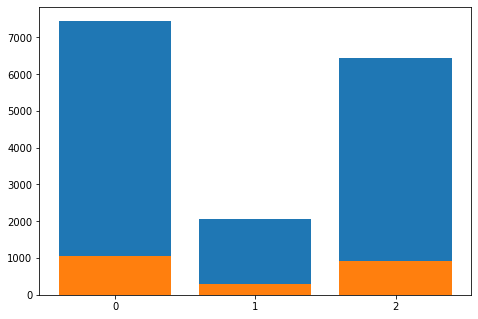

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['0', '1', '2']
students = [Y_train[Y_train== 0].count(),Y_train[Y_train== 1].count(),Y_train[Y_train== 2].count()]
students2= [Y_test[Y_test== 0].count(),Y_test[Y_test== 1].count(),Y_test[Y_test== 2].count()]
ax.bar(langs, students)
ax.bar(langs, students2)
plt.show()

Label 1 has very few instances so we expect that it has a lower score than the other 2 labels. 

## Features Extraction


### GloVe representation

Load pre-trained GloVe vectors into a dictionary.

In [ ]:
!pip install torchtext


In [ ]:
embeddings_dict = {}
with open("/content/drive/MyDrive/Colab Notebooks/Artificial Intelligence II/glove.twitter.27B.200d.txt.gz (Unzipped Files)/glove.twitter.27B.200d.txt", 'r', encoding="utf-8") as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    embeddings_dict[word]=vector

Find the vector for each word in each tweet and for every tweet keep the average of each dimesion of its words.

Some words do not exist in the pretrained model and in some tweets there isn't any word that matches. So I filled those tweets with zeros.  

In [ ]:

max = 1

def find_glove(text):
  tokens = word_tokenize(text.lower())
  global max
  if len(tokens)>max:
    max = len(tokens)
  res = [ embeddings_dict[token] for token in tokens if (token in embeddings_dict) ]
  res = res[:31]
  if len(res)<31:
    for i in range(31-len(res)):
      res.append(np.zeros(200))
  # print([ token for token in tokens if (token not in embeddings_dict) ] )
  # if (len(res) == 0):
  #   res = np.zeros(50)
  # else:
  #   res = np.stack(res, axis=0)
  #   res = np.average(res, axis=0).flatten()
  return res

df_train['features'] = df_train['cleanglove_tweet'].apply(find_glove)
df_test['features'] = df_test['cleanglove_tweet'].apply(find_glove)
df_train['features']

0        [[-0.16063, -0.28647, -0.60789, 0.42767, -0.11...
1        [[-0.33784, 0.54451, -0.1921, 0.43394, -0.4804...
2        [[-0.33915, -0.28546, -0.26841, 0.014209, 0.23...
3        [[0.34601, 0.30425, -0.098192, 0.08868, -0.359...
4        [[0.2101, -0.21056, -0.36659, -0.37312, 0.0773...
                               ...                        
15971    [[0.15358, -0.30126, -0.3615, 0.24909, 0.72131...
15972    [[0.061424, 0.42365, -0.13984, 0.26585, -0.215...
15973    [[0.058755, 0.018929, 0.24508, 0.021967, -0.23...
15974    [[0.14571, -0.31397, -0.39098, -0.16087, -0.02...
15975    [[-0.48751, 0.11036, 0.16039, -0.15214, -0.217...
Name: features, Length: 15976, dtype: object

### TF-IDF representation

Apply the simple preprocessing to the tf-idf's tweets.

In [ ]:

df_train['cleantfidf_tweet'] = df_train['tweet'].apply(tweets_cleaning)
df_test['cleantfidf_tweet'] = df_test['tweet'].apply(tweets_cleaning)

For the TF-IDF vectorization I used unigrams & bigrams for a better representation of the tweets and connections between words. I tried 0.01, 0.002 and 0.001 for the min_df parameter. 0.01 resulted in very little features that were not enough to represent the dataset well. 0.002 is the value that I worked best in Homework 1, but 0.001 did better in this one.

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=1.0, min_df=0.001, stop_words='english', lowercase=True)

tfidf_vectorizer.fit(df_train['cleantfidf_tweet'])

tfidf_train = tfidf_vectorizer.transform(df_train['cleantfidf_tweet'])
print(tfidf_train.shape)
print(tfidf_vectorizer.get_feature_names_out())
tfidf_test = tfidf_vectorizer.transform(df_test['cleantfidf_tweet'])
print(tfidf_test.shape)

(15976, 1900)
['10' '100' '1000' ... 'yr' 'yrs' 'zero']
(2282, 1900)


## Bidirectional RNN

### dokimh

In [ ]:
# # Imports
# import torch
# import torchvision
# import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
# import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
# import torch.nn.functional as F  # All functions that don't have any parameters
# from torch.utils.data import (
#     DataLoader,
# )  # Gives easier dataset managment and creates mini batches
# import torchvision.datasets as datasets  # Has standard datasets we can import in a nice way
# import torchvision.transforms as transforms  # Transformations we can perform on our dataset

# # Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Hyperparameters
# input_size = 28
# sequence_length = 28
# num_layers = 2
# hidden_size = 256
# num_classes = 10
# learning_rate = 0.001
# batch_size = 64
# num_epochs = 2

# # Create a bidirectional LSTM
# class BRNN(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes):
#         super(BRNN, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(
#             input_size, hidden_size, num_layers, batch_first=True, bidirectional=True
#         )
#         self.fc = nn.Linear(hidden_size * 2, num_classes)

#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
#         c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)

#         out, _ = self.lstm(x, (h0, c0))
#         out = self.fc(out[:, -1, :])

#         return out


# # Load Data
# train_dataset = datasets.MNIST(
#     root="dataset/", train=True, transform=transforms.ToTensor(), download=True
# )

# test_dataset = datasets.MNIST(
#     root="dataset/", train=False, transform=transforms.ToTensor(), download=True
# )

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

# # Initialize network
# model = BRNN(input_size, hidden_size, num_layers, num_classes).to(device)

# # Loss and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Train Network
# for epoch in range(num_epochs):
#     for batch_idx, (data, targets) in enumerate(train_loader):
#         # Get data to cuda if possible
#         data = data.to(device=device).squeeze(1)
#         targets = targets.to(device=device)

#         # forward
#         scores = model(data)
#         loss = criterion(scores, targets)

#         # backward
#         optimizer.zero_grad()
#         loss.backward()

#         # gradient descent or adam step
#         optimizer.step()

# # Check accuracy on training & test to see how good our model


# def check_accuracy(loader, model):
#     if loader.dataset.train:
#         print("Checking accuracy on training data")
#     else:
#         print("Checking accuracy on test data")

#     num_correct = 0
#     num_samples = 0
#     model.eval()

#     with torch.no_grad():
#         for x, y in loader:
#             x = x.to(device=device).squeeze(1)
#             y = y.to(device=device)

#             scores = model(x)
#             _, predictions = scores.max(1)
#             num_correct += (predictions == y).sum()
#             num_samples += predictions.size(0)

#         print(
#             f"Got {num_correct} / {num_samples} with accuracy  \
#               {float(num_correct)/float(num_samples)*100:.2f}"
#         )

#     model.train()


# check_accuracy(train_loader, model)
# check_accuracy(test_loader, model)

### kanoniko

In [ ]:
# Create a bidirectional LSTM
class BRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, cell, attention=True):
        super(BRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell = cell
        self.bidirectional = True
        self.attention = attention
        self.scale = 1. / math.sqrt(hidden_size)
        if (cell == 'LSTM'):
          self.lstm = nn.LSTM(
              input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=0.3
          )
        else:
          self.lstm = nn.GRU(
              input_size, hidden_size, num_layers, batch_first=True, bidirectional=True
          )
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)

        if (self.cell == 'LSTM'):
          out, hidden = self.lstm(x, (h0, c0))
          hidden = hidden[1]
        else:
          out, hidden = self.lstm(x)

        if (self.attention==True):
            # print("hi")
            if (self.bidirectional==True):
                hidden = torch.cat([hidden[-1], hidden[-2]], dim=1) # concatinate the last 2 hidden cells (backward & forward)
            else:
                hidden = hidden[-1]

            query = hidden.unsqueeze(1) # [BxQ] -> [Bx1xQ]
            values = out
            # print("query", query.shape)
            # print("keys", keys.shape)
            # keys = out.transpose(1,2) # [BxTxK] -> [BxKxT]
            # print("keys", keys.shape)
            attention_scores = torch.bmm(query, out.transpose(1,2)) # [Bx1xQ]x[BxKxT] -> [Bx1xT]
            attention_distribution = F.softmax(attention_scores.mul_(self.scale), dim=2) # scale, normalize

            # out = out # [TxBxV] -> [BxTxV]
            # print("values", values.shape)
            out = torch.bmm(attention_distribution, out).squeeze(1) #[Bx1xT]x[BxTxV] -> [BxV]

            out = self.fc(out)
        else:
            out = self.fc(out[:, -1, :])
        
        return out

In [ ]:
# set_seed()
# np.random.seed(20)
# torch.manual_seed(20)
# Hyperparameters
input_size = 200
sequence_length = 31 # length inside a batch
num_layers = 2
hidden_size = 128
num_classes = 3
learning_rate = 0.01
batch_size = 128
cell = 'LSTM'
epochs = 5

In [ ]:
# from torchtext.legacy.data import BucketIterator
# Load Data
# train_features = np.stack(df_train['features'])
set_seed()
train_features = df_train['features']
x = torch.tensor(train_features, dtype=torch.float)
# from torchtext.legacy.data import Dataset
y = torch.tensor(df_train['label'], dtype=torch.long)
# print(x)
print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

dataset = torch.utils.data.TensorDataset(x, y)

# train_features = df_train['features'].to_numpy().flatten()
train_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_features = df_test['features']
x_test = torch.tensor(test_features, dtype=torch.float)
# from torchtext.legacy.data import Dataset
y_test = torch.tensor(df_test['label'], dtype=torch.long)

y_test_3 = np.array(pd.get_dummies(y_test.detach().numpy()))
y_test_3 = torch.tensor(y_test_3, dtype=torch.float)
# print(x)
print(f"x shape: {x_test.shape}")
print(f"y shape: {y_test.shape}")


x shape: torch.Size([15976, 31, 200])
y shape: torch.Size([15976])
x shape: torch.Size([2282, 31, 200])
y shape: torch.Size([2282])


In [ ]:

# test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

# train_features = df_train['features'].to_numpy().flatten()
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)

# train_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

x_test = x_test.to(device=device).squeeze(1)
y_test_3 = y_test_3.to(device=device)

# Initialize network
attention_dim = 2*hidden_size
model = BRNN(input_size, hidden_size, num_layers, num_classes, cell).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

epoch_loss = []
validation_loss = []

# Train Network
for epoch in range(epochs):
  model.train()
  batch_losses = []
  for batch_idx, (data, targets) in enumerate(train_loader):
    # Get data to cuda if possible
    data = data.to(device=device).squeeze(1)
    targets = targets.to(device=device)

    # forward
    scores = model(data)
    loss = criterion(scores, targets)

    batch_losses.append(loss.item())

    # backward
    optimizer.zero_grad()
    loss.backward()

    # Clip params
    for param in model.parameters():
        if param.grad is None:
            continue
        grad_val = torch.clamp(param.grad, -5, 5)

    # gradient descent or adam step
    optimizer.step()
      
  epoch_loss.append(sum(batch_losses)/len(train_loader))
  model.eval()
  with torch.no_grad():
    y_test_pred = model(x_test)

  val_loss = criterion(y_test_pred, y_test_3)

  validation_loss.append(val_loss.item())
  print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(train_loader):.5f}")
      

# Check accuracy on training & test to see how good our model


# def check_accuracy(loader, model):

#     num_correct = 0
#     num_samples = 0
#     model.eval()

#     with torch.no_grad():
#         for x, y in loader:
#             x = x.to(device=device).squeeze(1)
#             y = y.to(device=device)

#             scores = model(x)
#             _, predictions = scores.max(1)
#             num_correct += (predictions == y).sum()
#             num_samples += predictions.size(0)

#         print(
#             f"Got {num_correct} / {num_samples} with accuracy  \
#               {float(num_correct)/float(num_samples)*100:.2f}"
#         )

#     model.train()


# check_accuracy(train_loader, model)
# check_accuracy(test_loader, model)



Epoch   0: Loss = 0.77514
Epoch   1: Loss = 0.65560
Epoch   2: Loss = 0.57079
Epoch   3: Loss = 0.47107
Epoch   4: Loss = 0.38716


In [ ]:
model.eval()

with torch.no_grad():
  scores = model(x_test)
  _, y_pred = scores.max(1)

if device==torch.device("cuda"):
   y_pred = y_pred.cpu()
   
print("all in one metrics: precision, recall, f1:", precision_recall_fscore_support(Y_test, y_pred))
print("all in one metrics: precision, recall, f1:", precision_recall_fscore_support(Y_test, y_pred, average='micro'))

f1 = f1_score(Y_test, y_pred, average=None)
print("F1 score for each class = ", f1 * 100, "%")
f1 = f1_score(Y_test, y_pred, average='micro')
print("F1 score = ", f1 * 100, "%")

print("precision: ", precision_score(Y_test, y_pred, average='micro'))

print("recall: ", recall_score(Y_test, y_pred, average='micro'))

model.train()

all in one metrics: precision, recall, f1: (array([0.79550102, 0.51984127, 0.65209125]), array([0.73051643, 0.44256757, 0.74484256]), array([0.76162506, 0.47810219, 0.69538773]), array([1065,  296,  921]))
all in one metrics: precision, recall, f1: (0.6989482909728308, 0.6989482909728308, 0.6989482909728308, None)
F1 score for each class =  [76.16250612 47.81021898 69.53877344] %
F1 score =  69.89482909728308 %
precision:  0.6989482909728308
recall:  0.6989482909728308


BRNN(
  (lstm): LSTM(200, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

### Confusion Matrix

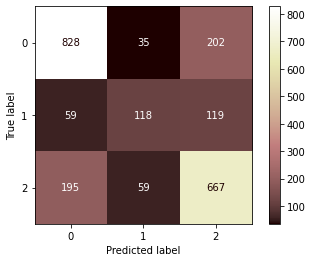

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(Y_test, y_pred, cmap=plt.cm.pink)  
plt.show()

### Learning Curves

[0.7838759455680847, 0.6812644958496094, 0.6079559543132782]
[0.7156838774681091, 0.6955229640007019, 0.6791391968727112]


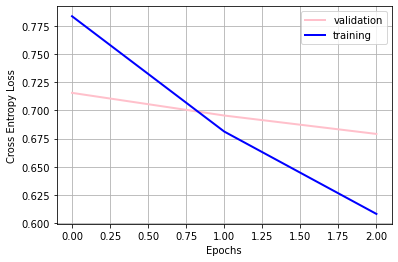

In [ ]:
# plot
print(epoch_loss)
print(validation_loss)
fig, ax = plt.subplots()
ax.plot(np.arange(epochs), validation_loss, color="pink", lw=2, label='validation')
ax.plot(np.arange(epochs), epoch_loss, color="b", lw=2, label='training')

ax.set_xlabel('Epochs')
ax.set_ylabel('Cross Entropy Loss')

ax.grid()
ax.legend(loc=0)
plt.show()
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


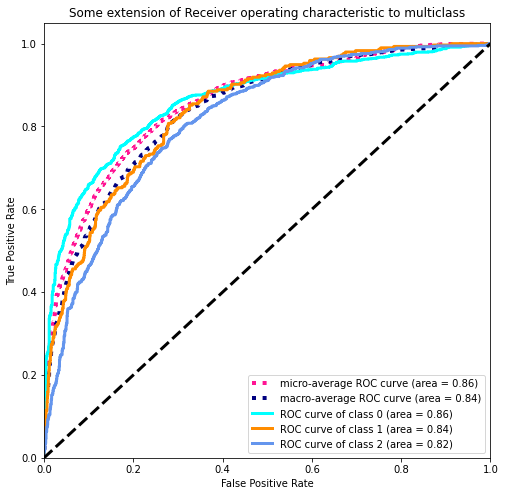

In [ ]:
# CODE FROM https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
# import numpy as np
# import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import roc_curve, auc
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

if device==torch.device("cuda"):
  print("here")
  y_score = scores.detach().cpu().numpy()
else:
  y_score = scores.detach().numpy()
# y_score = y_pred_3
y_test = np.array(pd.get_dummies(Y_test))
n_classes = 3
# print(y_score)
# print(y_test)
# print(n_classes)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
################################################################################

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,8))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=3,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

### Skip connections

In [ ]:
# set_seed()
# np.random.seed(20)
# torch.manual_seed(20)
# Hyperparameters
input_size = 200
sequence_length = 31 # length inside a batch
num_layers = 2
hidden_size = 64
num_classes = 3
learning_rate = 0.01
batch_size = 128
cell = 'GRU'
epochs = 7

[link text](https://www.slideshare.net/fgodin/skip-residual-and-densely-connected-rnn-architectures)

In [ ]:
from torchtext import vocab
from torchtext.legacy.data import Field,Dataset,LabelField,BucketIterator,TabularDataset

In [ ]:
vector_length = 128
glove_length  = 200
glove_package  = vocab.Vectors(r"/content/drive/MyDrive/Colab Notebooks/Artificial Intelligence II/glove.twitter.27B.200d.txt.gz (Unzipped Files)/glove.twitter.27B.200d.txt")

###dokimes

In [ ]:
df_train

,tweet,label,cleanglove_tweet,features,cleantfidf_tweet
0,Sip N Shop Come thru right now #Marjais #Popul...,0,sip n shop come thru right marjais popularnobo...,"[[-0.16063, -0.28647, -0.60789, 0.42767, -0.11...",sip n shop come thru right marjais popularnobo...
1,I don't know about you but My family and I wil...,1,dont know family take covid19 vaccine anytime ...,"[[-0.33784, 0.54451, -0.1921, 0.43394, -0.4804...",dont know family take covid19 vaccine anytime ...
2,@MSignorile Immunizations should be mandatory....,2,msignorile immunizations mandatory period okla...,"[[-0.33915, -0.28546, -0.26841, 0.014209, 0.23...",msignorile immunizations mandatory period okla...
3,President Obama spoke in favor of vaccination ...,0,president obama spoke favor vaccination childr...,"[[0.34601, 0.30425, -0.098192, 0.08868, -0.359...",president obama spoke favor vaccination childr...
4,"""@myfoxla: Arizona monitoring hundreds for mea...",0,myfoxla arizona monitoring hundreds measles li...,"[[0.2101, -0.21056, -0.36659, -0.37312, 0.0773...",myfoxla arizona monitoring hundreds measles li...
...,...,...,...,...,...
15971,@Salon if u believe the anti-vax nutcases caus...,1,salon u believe antivax nutcases caused measle...,"[[0.15358, -0.30126, -0.3615, 0.24909, 0.72131...",salon u believe antivax nutcases caused measle...
15972,How do you feel about parents who don't #vacci...,0,feel parents dont vaccinate kids\r\n\r\nmeasle...,"[[0.061424, 0.42365, -0.13984, 0.26585, -0.215...",feel parents dont vaccinate kids\r\n\r\nmeasle...
15973,70 Preschoolers Tested for Measles in Simi Val...,0,70 preschoolers tested measles simi valley,"[[0.058755, 0.018929, 0.24508, 0.021967, -0.23...",70 preschoolers tested measles simi valley
15974,Finance Minister: Budget offers room to procur...,0,finance minister budget offers room procure co...,"[[0.14571, -0.31397, -0.39098, -0.16087, -0.02...",finance minister budget offers room procure co...


In [ ]:
# df_train.drop(['tweet'], axis=1, inplace=True)
# df_test.drop(['tweet'], axis=1, inplace=True)

In [ ]:

# df_train.rename(columns={'cleanglove_tweet':'text'}, inplace=True)
# df_test.rename(columns={'cleanglove_tweet':'text'}, inplace=True)
# df_train.to_csv('train.csv', index=False)
# df_test.to_csv('test.csv', index=False)

TEXT = Field(tokenize = 'spacy', include_lengths=True)

LABEL = LabelField(dtype = torch.float)

train_val_fields = [
  ('text', TEXT), # process it as text
  ('label', LABEL) # process it as label
]

TEXT = Field(tokenize = 'spacy', include_lengths=True)
LABEL = LabelField(dtype = torch.float)

fields = {'text': ('text', TEXT), 'label': ('label', LABEL)}

train_ds, test_ds = TabularDataset.splits(path='/content/', train='train.csv', test='test.csv', format='csv', fields=fields)
print(vars(train_ds[0]))

vocab_size = 20000
# build the vocabulary for both of the fields
TEXT.build_vocab(train_ds,  max_size = vocab_size, vectors = glove_package, unk_init=torch.Tensor.normal_)
LABEL.build_vocab(train_ds)

# create the 2 iterators
train_loader, test_loader = BucketIterator.splits((train_ds, test_ds), 
    batch_size = 128, device = device, sort_within_batch = True, sort_key = lambda x: len(x.text,))

KeyboardInterrupt: ignored

Creating datasets





In [ ]:
class CustomTextDataset(Dataset):
    def __init__(self, text, labels):
        self.labels = labels

        def find_rep(text):
            tokens = word_tokenize(text.lower())
            res = [ embeddings_dict[token] for token in tokens if (token in embeddings_dict) ]
            return res
        
        self.text = text.apply(find_rep)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.text[idx]
        sample = {"Text": data, "Class": label}
        return sample

train_dataset = CustomTextDataset(df_train['text'], df_train['label'])
test_dataset = CustomTextDataset(df_test['text'], df_test['label'])

len(train_dataset[2]['Text'])
train_dataset[2]['Text']

In [ ]:
batch_size=128

train_loader, test_loader = BucketIterator.splits(
    (train_dataset, test_dataset),          # Datasets for iterator to draw data from
    batch_sizes=(batch_size, batch_size),   # Tuple of train and validation batch sizes.
    device=device,                        # Device to load batches on.
    sort_key=lambda x: len(x),      # Function to use for sorting examples.
    repeat=True,                            # Repeat the iterator for multiple epochs.
    sort=False,                             # Sort all examples in data using `sort_key`.
    shuffle=True,                           # Shuffle data on each epoch run.
    sort_within_batch=True,                 # Use `sort_key` to sort examples in each batch.
)

for batch in train_loader:
    print(batch)

In [ ]:
# Text tokenizer function - dummy tokenizer to return same text.
# Here you will use your own tokenizer.
text_tokenizer = lambda x : x

# Label tokenizer - dummy label encoder that returns same label.
# Here you will add your own label encoder.
label_tokenizer = lambda x: x

# Data field for text column - invoke tokenizer.
TEXT = torchtext.data.Field(sequential=True, tokenize=text_tokenizer, lower=False)

# Data field for labels - invoke tokenize label encoder.
LABEL = torchtext.data.Field(sequential=True, tokenize=label_tokenizer, use_vocab=False)

# Create data fields as tuples of description variable and data field.
datafields = [("label", LABEL),
              ("text", TEXT)]

# Since we have have tab separated data we use TabularDataset
train_dataset, valid_dataset = torchtext.data.TabularDataset.splits(
    
                                                # Path to train and validation.
                                                path=data_path,

                                                # Train data filename.
                                                train=train_filename,

                                                # Validation file name.
                                                validation=test_filename,

                                                # Format of local files.
                                                format='tsv',

                                                # Check if we have header.
                                                skip_header=False,

                                                # How to handle fields.
                                                fields=datafields)

### sxedon teliko

In [ ]:
df_train.drop(columns=['tweet'],inplace=True)

In [ ]:
df_test.drop(columns=['tweet'],inplace=True)

In [ ]:
text_field = Field(tokenize=nltk.word_tokenize,lower=True,sequential=True) # tokenize text using word_tokenize and convert to numerical form using default parameters
label_field = Field(sequential=False, use_vocab=False)

fields = [('label',label_field),('cleanglove_tweet',text_field)]

preprocessed_text = df_train['cleanglove_tweet'].apply(lambda x: text_field.preprocess(x))
text_field.build_vocab(preprocessed_text,vectors=glove_package)

from torchtext.legacy.data import Dataset, Example
train_dataset = Dataset(
    examples=[Example.fromlist(list(r),fields) for i,r in df_train.iterrows()],
    fields=fields)


https://gmihaila.medium.com/better-batches-with-pytorchtext-bucketiterator-12804a545e2a

In [ ]:
# text_field_test = Field(tokenize=nltk.word_tokenize,lower=True,fix_length = vector_length,sequential=True) # tokenize text using word_tokenize and convert to numerical form using default parameters
# label_field_test = Field(sequential=False, use_vocab=False)

# fields_test = [('target',label_field_test),('processed_tweets',text_field_test)]

preprocessed_text_test = df_test['cleanglove_tweet'].apply(lambda x: text_field.preprocess(x))
text_field.build_vocab(preprocessed_text_test,vectors=glove_package)

from torchtext.legacy.data import Dataset, Example
test_dataset = Dataset(
    examples=[Example.fromlist(list(r),fields) for i,r in df_test.iterrows()],
    fields=fields)

batch_size=128

train_loader, test_loader = BucketIterator.splits(
    datasets=(train_dataset, test_dataset),          # Datasets for iterator to draw data from
    batch_sizes=(batch_size, batch_size),   # Tuple of train and validation batch sizes.
    sort=False,            
    device=device,        # Device to load batches on.
    sort_key=lambda x: len(x.cleanglove_tweet),      # Function to use for sorting examples.
    # repeat=True,                            # Repeat the iterator for multiple epochs.
    # sort=False,                             # Sort all examples in data using `sort_key`.
    shuffle=True,                           # Shuffle data on each epoch run.
    sort_within_batch=False                 # Use `sort_key` to sort examples in each batch.
)

# for batch in train_loader:
#     print(batch)

In [ ]:


# Create a bidirectional LSTM
class BRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, cell, embedding):
        super(BRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell = cell
        self.dropout = nn.Dropout(p=0.3)
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding))
        
        if (cell == 'LSTM'):
            rnn = nn.LSTM
        else:
            rnn = nn.GRU

        self.rnns = nn.ModuleList()
        for i in range(num_layers):
            input_size = input_size if i == 0 else hidden_size*2
            self.rnns.append(rnn(input_size, hidden_size, 1, bidirectional=True))
        
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        # h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        # c0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)

        sent_variable = self.embedding(x)
        # print("sent", sent_variable.shape)
        # out, _ = self.lstm(x, (h0, c0))

        # outputs = []
        for i in range(self.num_layers):
            if i != 0:
                sent_variable = self.dropout(sent_variable.detach())
            # print(i)
            # print("rnn input:" ,sent_variable.shape)
            out, hidden = self.rnns[i](sent_variable.detach())
            # print("rnn output:", out.shape)
            # outputs.append(out)
            # sent_variable = out
            if i == 0:
                sent_variable = out.detach()
            sent_variable = torch.cat((sent_variable,out.detach()),dim=0)


        # print("out", out.shape)
        out = self.fc(out[-1, :, :])
        # print("out", out.shape)

        return out

# test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

# train_features = df_train['features'].to_numpy().flatten()
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)

# train_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

# x_test = x_test.to(device=device).squeeze(1)
# y_test_3 = y_test_3.to(device=device)

# Initialize network
embedding = text_field.vocab.vectors
model = BRNN(input_size, hidden_size, num_layers, num_classes, cell, embedding).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

epoch_loss = []
validation_loss = []

# Train Network
i=0
for epoch in range(epochs):
    model.train()
    batch_losses = []
    for batch in train_loader:
        # print (i)
        i=i+1
        # Get data to cuda if possible
        data = batch.cleanglove_tweet
        targets = batch.label

        # print(data.shape)

        data = data.to(device=device).squeeze(1)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        # print(scores.shape)
        loss = criterion(scores, targets)

        batch_losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # Clip params
        for param in model.parameters():
            if param.grad is None:
                continue
            grad_val = torch.clamp(param.grad, -5, 5)

        # gradient descent or adam step
        optimizer.step()
        
    epoch_loss.append(sum(batch_losses)/len(train_loader))
    
    model.eval()
    batch_val_losses = []
    with torch.no_grad():
        for test_batch in test_loader:
            x = test_batch.cleanglove_tweet
            y = test_batch.label
            x = x.to(device=device).squeeze(1)
            y = y.to(device=device)

            scores = model(x)
            loss = criterion(scores, y)

            batch_val_losses.append(loss.item())

        validation_loss.append(sum(batch_val_losses)/len(test_loader))

    print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(train_loader):.5f}")
    # if (val_loss>validation_loss[epoch-1]+0.3): #early stopping
    n_epochs = epoch+1
    #     break 


Epoch   0: Loss = 0.96002
Epoch   1: Loss = 0.78759
Epoch   2: Loss = 0.75445
Epoch   3: Loss = 0.72007
Epoch   4: Loss = 0.69536
Epoch   5: Loss = 0.68294
Epoch   6: Loss = 0.66723


In [ ]:
model.eval()
total_scores = torch.empty((0,3))
print(total_scores.shape)
with torch.no_grad():
  for test_batch in test_loader:
    x = test_batch.cleanglove_tweet
    y = test_batch.label
    x = x.to(device=device).squeeze(1)
    y = y.to(device=device)

    scores = model(x)
    # print(scores.shape)
    total_scores = torch.concat((total_scores, scores), 0)
            

if device==torch.device("cuda"):
   y_pred = y_pred.cpu()
   
print("all in one metrics: precision, recall, f1:", precision_recall_fscore_support(Y_test, y_pred))
print("all in one metrics: precision, recall, f1:", precision_recall_fscore_support(Y_test, y_pred, average='micro'))

f1 = f1_score(Y_test, y_pred, average=None)
print("F1 score for each class = ", f1 * 100, "%")
f1 = f1_score(Y_test, y_pred, average='micro')
print("F1 score = ", f1 * 100, "%")

print("precision: ", precision_score(Y_test, y_pred, average='micro'))

print("recall: ", recall_score(Y_test, y_pred, average='micro'))

model.train()

torch.Size([0, 3])
all in one metrics: precision, recall, f1: (array([0.84468339, 0.60122699, 0.60608424]), array([0.66384977, 0.33108108, 0.84364821]), array([0.74342797, 0.42701525, 0.70540172]), array([1065,  296,  921]))
all in one metrics: precision, recall, f1: (0.6932515337423313, 0.6932515337423313, 0.6932515337423313, None)
F1 score for each class =  [74.34279706 42.70152505 70.54017249] %
F1 score =  69.32515337423312 %
precision:  0.6932515337423313
recall:  0.6932515337423313


BRNN(
  (dropout): Dropout(p=0.3, inplace=False)
  (embedding): Embedding(7769, 200)
  (rnns): ModuleList(
    (0): LSTM(200, 128, bidirectional=True)
    (1): LSTM(256, 128, bidirectional=True)
  )
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

[0.960015926361084, 0.7875914320945739, 0.7544513835906982, 0.7200671362876893, 0.6953603229522705, 0.6829440083503723, 0.6672297534942627]
[0.815495726135042, 0.7714263101418813, 0.7472913397683038, 0.7139216694566939, 0.6911003457175361, 0.7076205412546793, 0.7098178002569411]


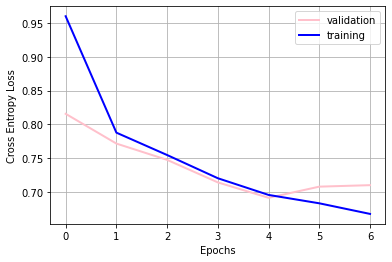

In [ ]:
# plot
n_epochs = epoch+1
print(epoch_loss)
print(validation_loss)
fig, ax = plt.subplots()
ax.plot(np.arange(n_epochs), validation_loss, color="pink", lw=2, label='validation')
ax.plot(np.arange(n_epochs), epoch_loss, color="b", lw=2, label='training')

ax.set_xlabel('Epochs')
ax.set_ylabel('Cross Entropy Loss')

ax.grid()
ax.legend(loc=0)
plt.show()